In [1]:
import gcsfs
import xarray as xr

# fs = gcsfs.GCSFileSystem()
# fs.ls('gs://leap-persistent/jbusecke/OM4_m2lines')

In [2]:
# xr.set_options(keep_attrs=True)

## Load an example of 'raw' OM4 data

In [3]:
ds = xr.open_dataset('gs://leap-persistent/jbusecke/OM4_m2lines/daily_combined.zarr', engine='zarr', chunks={})
ds

<xarray.Dataset> Size: 91GB
Dimensions:       (yq: 1081, xq: 1441, yh: 1080, xh: 1440, experiment: 2,
                   time: 1827, nv: 2)
Coordinates: (12/34)
    Coriolis      (yq, xq) float32 6MB dask.array<chunksize=(271, 361), meta=np.ndarray>
    areacello     (yh, xh) float32 6MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 6MB dask.array<chunksize=(271, 361), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 6MB dask.array<chunksize=(270, 361), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 6MB dask.array<chunksize=(271, 360), meta=np.ndarray>
    basin         (yh, xh) int32 6MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    ...            ...
    wet_u         (yh, xq) float32 6MB dask.array<chunksize=(270, 361), meta=np.ndarray>
    wet_v         (yq, xh) float32 6MB dask.array<chunksize=(271, 360), meta=np.ndarray>
  * xh            (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * xq            (xq) float64 12kB -299.8 -299.6 -299.3 ... 59.66 59.91 60.16
  * yh            (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * yq            (yq) float64 9kB -80.43 -80.35 -80.27 ... 89.78 89.89 90.0
Data variables:
    average_DT    (experiment, time) timedelta64[ns] 29kB dask.array<chunksize=(2, 1827), meta=np.ndarray>
    average_T1    (experiment, time) datetime64[ns] 29kB dask.array<chunksize=(2, 1827), meta=np.ndarray>
    average_T2    (experiment, time) datetime64[ns] 29kB dask.array<chunksize=(2, 1827), meta=np.ndarray>
    ssu           (experiment, time, yh, xq) float32 23GB dask.array<chunksize=(1, 20, 1080, 1441), meta=np.ndarray>
    ssv           (experiment, time, yq, xh) float32 23GB dask.array<chunksize=(1, 20, 1081, 1440), meta=np.ndarray>
    time_bnds     (experiment, time, nv) object 58kB dask.array<chunksize=(2, 1827, 2), meta=np.ndarray>
    tos           (experiment, time, yh, xh) float32 23GB dask.array<chunksize=(1, 20, 1080, 1440), meta=np.ndarray>
    zos           (experiment, time, yh, xh) float32 23GB dask.array<chunksize=(1, 20, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 20080101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_bugfixes_JRA55do1.5_cycle1

In [ ]:
from ... import plot_surface_bias

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar


def plot_surface_bias(ds_ref:xr.Dataset, ds:xr.Dataset, ax=None, variable='tos') -> matplotlib.axes._axes.Axes:
    if ax is None:
        ax = plt.gca()

    def check_ax(ax):
        if not isinstance(ax, cartopy.mpl.geoaxes.GeoAxes):
            raise ValueError("Axis has to be `cartopy.mpl.geoaxes.GeoAxes`. Pass `projection=ccrs.<some_projection>` to the axis creation.")

    # xarray nicely handles the labeling for us. Making sure we are not loosing attributes like units!
    with xr.set_options(keep_attrs=True):
        da_ref = ds_ref[variable].mean('time', keep_attrs=True)
        da = ds[variable].mean('time', keep_attrs=True)
        bias = da-da_ref

        bias = bias.squeeze(drop=True)
        
    with ProgressBar():
        print("Loading Plot Data")
        bias = bias.load()
        
    bias.plot(
        ax=ax,
        x='geolon',
        y='geolat',
        transform=ccrs.PlateCarree(),
        vmax=3)
    ax.coastlines()
    return ax 

Loading Plot Data
[########################################] | 100% Completed | 1.12 sms


<GeoAxes: xlabel='Longitude of tracer (T) points\n[degrees_east]', ylabel='Latitude of tracer (T) points\n[degrees_north]'>

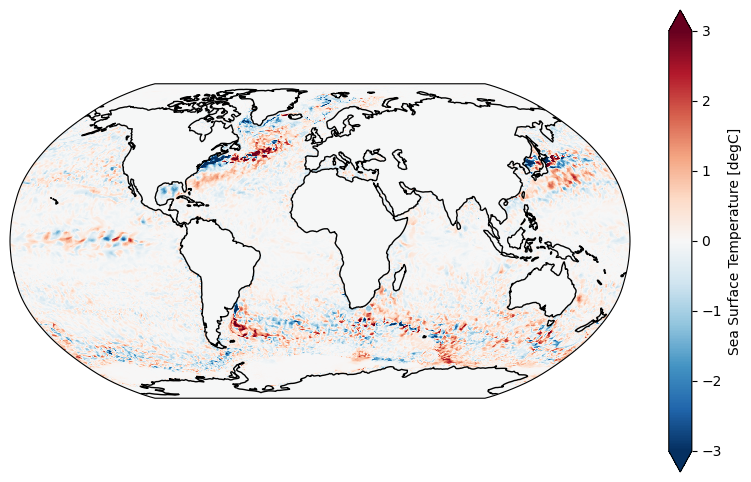

In [5]:
ds_ref = ds.sel(experiment='unparameterized')
ds_new = ds.sel(experiment='ZB2020')

standardized_figsize=[10,6]

fig,ax = plt.subplots(figsize=standardized_figsize, subplot_kw=dict(projection=ccrs.Robinson()))
plot_surface_bias(ds_ref.isel(time=slice(0,10)), ds_new.isel(time=slice(0,10)), ax=ax)

## Try with a different dataset (CM4 from CMIP6)

Note the CMIP data follows different naming conventions! We need to rename dimensions/coordinates to match the native GFDL output.

In [6]:
def preprocess_cmip(ds:xr.Dataset) -> xr.Dataset:
    ds = ds.rename({
        'x':'xh',
        'y':'yh',
        'lon':'geolon',
        'lat':'geolat',
    })
    return ds

In [7]:
import intake
# uncomment/comment lines to swap catalogs
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog.json" # Only stores that pass current tests
col = intake.open_esm_datastore(url)
cat = col.search(source_id='GFDL-CM4', variable_id='tos', experiment_id='historical', grid_label='gn', table_id='Oday')
ddict = cat.to_dataset_dict()
ds_cmip = preprocess_cmip(ddict['CMIP.NOAA-GFDL.GFDL-CM4.historical.Oday.gn'])
ds_cmip


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<xarray.Dataset> Size: 375GB
Dimensions:            (bnds: 2, yh: 1080, xh: 1440, vertex: 4, time: 60225,
                        variant_label: 1, sub_experiment_id: 1)
Coordinates:
  * bnds               (bnds) float64 16B 1.0 2.0
    geolat             (yh, xh) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds           (yh, xh, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    geolon             (yh, xh) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds           (yh, xh, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time               (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31...
    time_bnds          (time, bnds) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
  * xh                 (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.78 60.03
  * yh                 (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.84 89.95
  * variant_label      (variant_label) object 8B 'r1i1p1f1'
  * sub_experiment_id  (sub_experiment_id) object 8B 'none'
Dimensions without coordinates: vertex
Data variables:
    tos                (variant_label, sub_experiment_id, time, yh, xh) float32 375GB dask.array<chunksize=(1, 1, 18, 1080, 1440), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                         CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                         CMIP
    branch_method:                       standard
    branch_time_in_child:                0.0
    branch_time_in_parent:               36500.0
    comment:                             <null ref>
    ...                                  ...
    intake_esm_attrs:sub_experiment_id:  none
    intake_esm_attrs:variant_label:      r1i1p1f1
    intake_esm_attrs:version:            v20180701
    intake_esm_attrs:zstore:             gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL...
    intake_esm_attrs:_data_format_:      zarr
    intake_esm_dataset_key:              CMIP.NOAA-GFDL.GFDL-CM4.historical.O...

Loading Plot Data
[########################################] | 100% Completed | 1.01 sms


<GeoAxes: title={'center': 'experiment = unparameterized'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

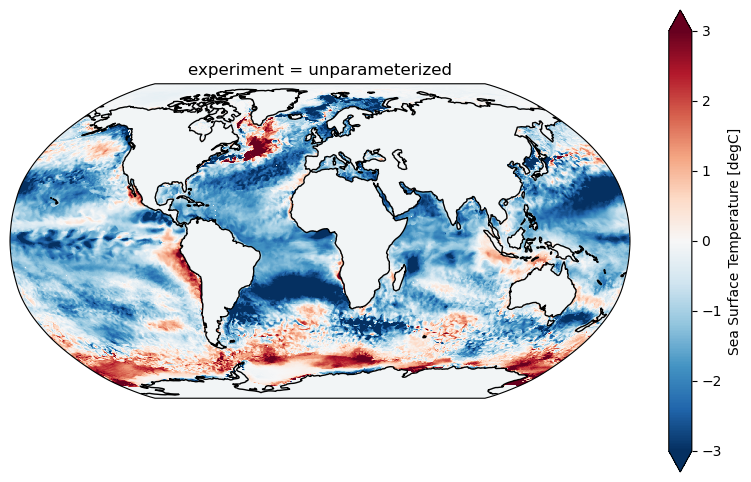

In [8]:
fig,ax = plt.subplots(figsize=standardized_figsize, subplot_kw=dict(projection=ccrs.Robinson()))
plot_surface_bias(ds_ref.isel(time=slice(0,10)), ds_cmip.isel(time=slice(0,10)), ax=ax)